# Lyft Challenge - Segmantic Segmentation

For this project I'll use the work I've done for the Udacity Semantic Segmentation Project.

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from random import randint
from glob import glob
import os
import os.path
import copy
import scipy
import math
import tensorflow as tf
import imageio
import shutil

%matplotlib inline

/anaconda3/envs/carnd-advdl-odlab/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data

I'll use the data provided for this challenge. It contains 1000 images with their pixel-per-pixel labels.

In [2]:
data_dir = "./data"

training_dataset = os.path.join(data_dir, "Train")
path_images = os.path.join(training_dataset, "CameraRGB")
path_labels = os.path.join(training_dataset, "CameraSeg")

list_images = glob(os.path.join(path_images, "*.png"))
list_labels = glob(os.path.join(path_labels, "*.png"))

size_dataset = len(list_images)
print("There are {} labeled images in the provided dataset".format(size_dataset))

image = imageio.imread(list_images[0])
image_size = [len(image[:, 0, 0]),
              len(image[0, :, 0]),
              len(image[0, 0, :])]
print("Image size: ({}, {}, {})".format(image_size[0],
                                        image_size[1],
                                        image_size[2]))

def plot_image(image_path):
    image = imageio.imread(image_path)
    plt.figure()
    plt.imshow(image)

def plot_label(label_path):
    image = imageio.imread(label_path)
    plt.figure()
    plt.imshow(image[:,:,0])

There are 1000 labeled images in the provided dataset
Image size: (600, 800, 3)


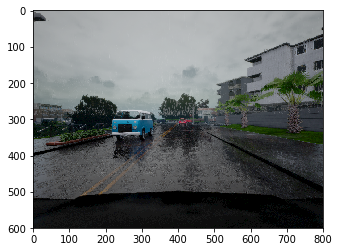

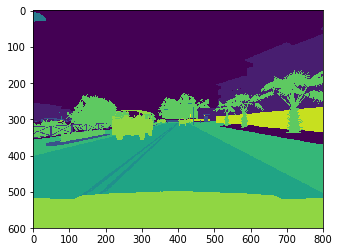

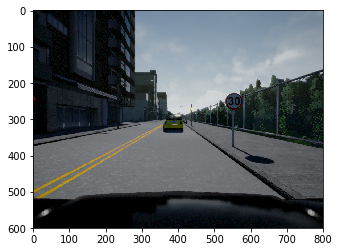

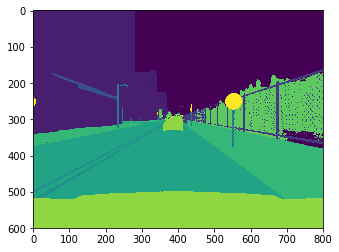

In [3]:
for i in range (2):
    random_image = randint(0, size_dataset)
    plot_image(list_images[random_image])
    plot_label(list_labels[random_image])

### Labels Preprocessing

Here are the labels given by the CARLA simulator:

| Value	| Tag |
:---:|:---:
|0|	None|
|1|	Buildings|
|2|	Fences|
|3|	Other|
|4|	Pedestrians|
|5|	Poles|
|6|	RoadLines|
|7|	Roads|
|8|	Sidewalks|
|9|	Vegetation|
|10|	Vehicles|
|11|	Walls|
|12|	TrafficSigns|

The goal is to detect the road and other cars. Therefore, I change the lane marking to be labeled 'road'.

It is useless to detect the hood of my car so I set this to be 'none'.

I do it only once and store the preprocessed labels to a folder.

In [4]:
def preprocess_label(label_image):
    # Identify lane marking pixels (label is 6)
    lane_marking_pixels = (label_image[:,:,0] == 6).nonzero()
    labels_new = copy.deepcopy(label_image)
    np.copy(label_image[:,:,0])
    # Set lane marking pixels to road (label is 7)
    labels_new[lane_marking_pixels] = 7
 
    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new

#new_label_array = np.zeros_like(label_image)
#new_label_array[:,:,0] = car_label
#new_label_array[:,:,1] = road_label
#new_label_array[:,:,2] = none_label

In [5]:
path_preprocessed_labels = os.path.join(training_dataset, "CameraPP")
list_pp_labels = glob(os.path.join(path_preprocessed_labels, "*.png"))

if len(list_pp_labels) < size_dataset:
    # Clean preprocessed labels dir
    if os.path.exists(path_preprocessed_labels):
        shutil.rmtree(path_preprocessed_labels)
    os.makedirs(path_preprocessed_labels)
    
    for label_path in list_labels:
        label = imageio.imread(label_path)
        pp_label = preprocess_label(label)
        imageio.imwrite(os.path.join(path_preprocessed_labels, os.path.basename(label_path)), pp_label)

print("Labels preprocessed.")

Labels preprocessed.


We can see that we can't see the lane marking anymore and the hood of the car is classified like the sky (`none`).

Original first then preprocessed.


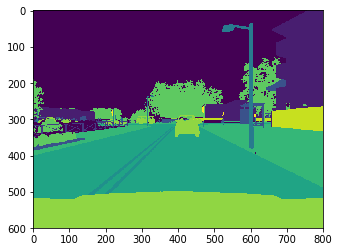

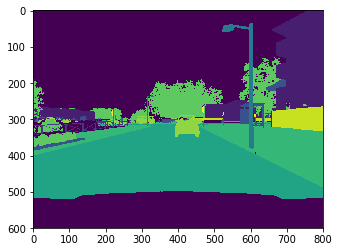

In [6]:
list_pp_labels = glob(os.path.join(path_preprocessed_labels, "*.png"))

print("Original first then preprocessed.")
rand = randint(0, size_dataset)
plot_label(list_labels[rand])
plot_label(list_pp_labels[rand])

### Image Preprocessing

The images have a fair amount of useless data. The hood of the car and the sky can be safely removed since there will never be any cars nor road there.

In [7]:
## Neural Network expected input image size
nn_image_shape = (160, 576)
clipped_shape = (150, 530)

def resize(image, clipped_shape, output_shape):
    return cv2.resize(image[clipped_shape[0]:clipped_shape[1], :, :],
                      (output_shape[1], output_shape[0]),
                      interpolation=cv2.INTER_AREA)
    
def resize_back(image, clipped_shape, output_shape):
    output_image = np.zeros(output_shape, np.uint8)
    output_image[clipped_shape[0]:clipped_shape[1], :, :] = cv2.resize(image,
                                                                       (output_shape[1], clipped_shape[1]-clipped_shape[0]),
                                                                       interpolation=cv2.INTER_AREA)
    return output_image

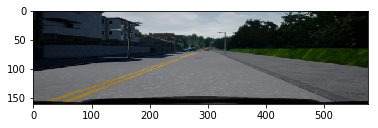

In [8]:
pp_image = resize(imageio.imread(list_images[0]), clipped_shape, nn_image_shape)
plt.figure()
plt.imshow(pp_image)

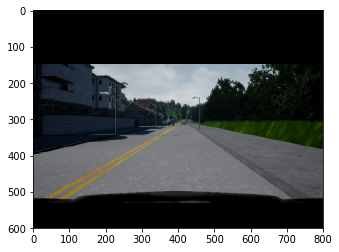

In [9]:
original_image = resize_back(pp_image, clipped_shape, image_size)
plt.figure()
plt.imshow(original_image)

## Load VGG16

I'm using a pre-trained VGG16. Here is how I load it.

In [10]:
from urllib.request import urlretrieve
import zipfile
    
def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))
    else:
        print('Model already retrieved. No download needed.')

### Helper Functions

First a couple of helper functions. Our output is an array of as any dimensions as we have classes - 13 by default, 3 for the given challenge.

The data comes in with all data on the red channel - 0-12 for the given class. I need to be able to return this format as well, so I have to convert from this image format to the multi-dimensional array - and vice versa.

In [11]:
#Make a map more colorful
def convertToColor(value):
    colors = [
        (255, 255, 255),   #0
        (255, 0, 0),      #1
        (0, 255, 0),      #2
        (0, 0, 255),      #3
        (255, 255, 0),    #4
        (127, 0, 255),    #5
        (51, 255, 51),    #6
        (255, 0, 127),    #7
        (127, 127, 127),  #8
        (0, 0, 0),        #9
        (0, 255, 255),  #10
        (0, 0, 100),      #11
        (100, 0, 0),      #12
    ]
    return colors[value[0]]

def colorizeMap(img):
    return [list( map(convertToColor, row) ) for row in img]

In [12]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    truths = [
        (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
    ]
    
    return truths[value[0]]

def truthToPixel(value):
    tmp = value.tolist()
    return (tmp.index(max(tmp)), 0, 0)

def imageToTruth(img):
    return [list(map(pixelToTruth, row)) for row in img]

def truthToImage(truth):
    return [list(map(truthToPixel, row)) for row in truth]

### Generator

A generator is a reentrant function to provide images and labels by batches.

In [13]:
def gen_batch_function(images_path, labels_path, image_shape):
    """
    Generate function to create batches of training data
    :param images_path: Path to folder that contains all the training images
    :param labels_path: Path to folder that contains all the label images
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(images_path, '*.png'))
        label_paths = glob(os.path.join(labels_path, '*.png'))
        
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for index, image_file in enumerate(image_paths[batch_i:batch_i + batch_size]):
                gt_image_file = os.path.join(label_paths[index])

                image = resize(imageio.imread(image_file), clipped_shape, nn_image_shape)
                gt_image = resize(imageio.imread(gt_image_file), clipped_shape, nn_image_shape)

                #gt_bg = np.all(gt_image == background_color, axis=2)
                #gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                #gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

if 0:
    for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
        map_file = os.path.join(label_paths[index])

        image = scipy.misc.imread(image_file)
        image = scipy.misc.imresize(image, image_shape)

        map_image = scipy.misc.imread(map_file)
        map_image = scipy.misc.imresize(map_image, image_shape)
        map_image = imageToTruth(map_image)

        images.append(image)
        maps.append(map_image)

    yield np.array(images), np.array(maps)        

In [33]:
# Test
gen_batch_fun = gen_batch_function(path_images,
                                   path_preprocessed_labels,
                                   image_size)
for image, labels in gen_batch_fun(20):
    pass

## Model

### Load Pre-trained VGG16

Load the VGG and return key aspects (keep_prob) and layers (input, layers 3, 4, and 7)

In [14]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    w1 = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    l3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    l4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    l7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return w1, keep, l3, l4, l7

### Build the FCN off of the VGG

In [15]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    beta = 1e-3
    stddev = 0.01

    conv_1x1_l7 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1,
                                   padding='SAME', 
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                   kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))
    
    conv_1x1_l4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1,
                                   padding='SAME', 
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                   kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))
    
    conv_1x1_l3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1,
                                   padding='SAME',
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                   kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))
    
    transposed_l7 = tf.layers.conv2d_transpose(conv_1x1_l7, num_classes, 4,
                                               strides=(2, 2),
                                               padding='SAME',
                                               kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                               kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))

    l7_l4 = tf.add(transposed_l7, conv_1x1_l4)

    transposed_l7_l4 = tf.layers.conv2d_transpose(l7_l4, num_classes, 4,
                                                  strides=(2, 2),
                                                  padding='SAME',
                                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))

    l7_l4_l3 = tf.add(transposed_l7_l4, conv_1x1_l3)

    output = tf.layers.conv2d_transpose(l7_l4_l3, num_classes, 16,
                                        strides=(8, 8),
                                        padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(beta))

    return output

### Logits & Optimizer

In [16]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1,num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                                labels=correct_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_operation = optimizer.minimize(cross_entropy_loss)
    return logits, train_operation, cross_entropy_loss

### Parameters

In [17]:
num_classes = 3 # none, road, car
initializer_stddev = 0.01
beta = 1e-3

## Training

In [20]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # _s for scalar to differentiate them from their placeholder
    learning_rate_s = 1e-5
    keep_prob_s = 0.5
    loss_log = []
    
    print(" ... Training ... \n")
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        print("EPOCH {} ...".format(epoch))
        batch_count = 0
        for image, labels in get_batches_fn(batch_size):
            batch_count += 1
            _, loss = sess.run([train_op, cross_entropy_loss], 
                               feed_dict={ input_image: image,
                                           correct_label: labels,
                                           keep_prob: keep_prob_s,
                                           learning_rate: learning_rate_s})
            print("Loss: = {:.3f}".format(loss))
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % 10 == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}/fcn_model".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
    print("Training finished.")
    return loss_log

The following cell triggers the training.

In [ ]:
saver = None

with tf.Session() as sess:
    
    maybe_download_pretrained_vgg(data_dir)
    vgg_path = os.path.join(data_dir, 'vgg')
    
    # Create function to get batches
    get_batches_fn = gen_batch_function(path_images,
                                        path_preprocessed_labels,
                                        image_size)

    # TensorFlow Placeholders
    correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
    nn_last_layer = layers(layer3_out, layer4_out, layer7_out, num_classes)
    logits, train_operation, cross_entropy_loss = optimize( nn_last_layer, 
                                                            correct_label, 
                                                            learning_rate, 
                                                            num_classes )

    #### Hyperparameters ####
    epochs = 1
    batch_size = 20

    print("Model created.")
    
    train_nn(sess,
             epochs,
             batch_size, 
             get_batches_fn, 
             train_operation, 
             cross_entropy_loss, 
             image_input, 
             correct_label, 
             keep_prob, 
             learning_rate)

    # Saver to save the model and later on reload it
    saver = tf.train.Saver()
    # Save the model
    save_path = saver.save(sess, "/model/model.ckpt")

Model already retrieved. No download needed.
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Model created.
 ... Training ... 

EPOCH 0 ...
Loss: = 13.929
Loss: = 12.871
Loss: = 12.494
Loss: = 12.287
Loss: = 12.454
Loss: = 12.770


In [ ]:
saver = None

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 10, 10, 0.75, 0.0001)
  

After training above, we don't have great results, but let's see what the network is doing.

I didn't expect great results - given the very tiny size of the dataset and the number of classes we have to define, I'd expect poor results. This is mostly to ensure we don't have any oddities in training and the network architecture *can* learn, and that our output looks even somewhat "correct".

In [ ]:
def execute_on_image(sess, model):

    chosen_image = "165"
    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure()
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    plt.figure()
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure()
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
    return output

In [ ]:
saver = None

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_9/fcn_model')
    
    results = execute_on_image(sess, model)

Not too bad for such a high loss - it mostly gets the car hood and the road - definitely didn't get the buildings or the fence posts.

I saved the model used for above as `13_classes_model.zip`

## Moving over to just 3 classes

With the dataset at the size it is, this network would never reach the level of clarity needed for all 13 classes. I'm going to now change some of the helper functions to convert data into a 3 class system - `roads`, `vehicles`, and `none`. This should make the network quite a bit better as it has less to learn.

In [ ]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    if value[0] == 7:
        return (0, 1, 0)
    elif value[0] == 10:
        return (0, 0, 1)
    else:
        return (1, 0, 0)

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 50, 10, 0.5, 0.0001)
  

Loss looks far better than before as I expected. Obviously we're purposely overfitting here - no sense in combatting overfitting on the first go-through (though with a dropout of `0.5` we're pretty good - but I'm not holding back any for generalized validation testing, or doing any data augmentation atm. Let's look at an example output just as before.

I'll have to modify the `execute_on_image` function in order to prepare it for the 3 class pictures and draw them correctly. Note that the truth images, since it's labeling their classes as different #'s (out of 13 still) - the colors will be different - we're looking for similar clustering.

In [ ]:
def execute_on_image(sess, model, chosen_image):

    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    # We're going to convert the truth to an image and back -
    # inefficient, but it should shape it back to the 
    # 3 classes
#     truth = imageToTruth(truthToImage(truth))
    plt.figure(figsize=(20,15))
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure(figsize=(20,15))
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
#     plt.figure(figsize=(20,15))
#     overlayed = cv2.addWeighted(image, 1.0, colorizedOutput, 0.5, 0)
#     plt.imshow(overlayed)
    
    return output

As a note, the model for this is saved as `3_classes_model.zip`.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "165")

Initial thought - the hood is problematic, but makes sense - the dataset always marks that as a car, so any pipeline that would work with this data would have to remove it anyway. As for the cars- it's not as fine-tuned as before, but it worked out pretty well - it *did* detect those as cars. Let's try another.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "396")

Here the results are less good - it seems the network doesn't quite get the car on the left - could be data, could be network.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "633")

After seeomg this, it seems that the network kind of just likes to identify cars as down range, and as a result it is often right. It's not generalizing super well as is. I also think the loss is reporting super low because it nails the hood, sky, and sides as nothing quite accuately - this buffs its score despite missing so much on vehicles. I'm going to try experimenting with a few hyperparameters and see what we can do from there.

I debated starting from the pretrained model used above, but abandoned that idea in fear that the network learned to activate the center of the image for cars and ignore the sides too much and I might not be able to teach it to generalize.

First, FCNs are apparently effected by image size used inside the network - this makes sense, since we lose detail as we shrink the image. This makes the network larger and slower, however, but it's worth exploring.

Above, we used an image size of `576x160`- originally I had grabbed this from a ratio calculator, but in review, I realize that this isn't correct - it should be a 4:3 aspect ratio, and it looks like I'm using a 16:10 ratio. I'm not quite sure *why* that occured, but its' definitely causing issues. So I'm going to just move forward using `256x256` - the square ratio fixes shape issues, and I needed to shrink it to keep network size manageable in order to increase batch size.

In [ ]:
image_shape = (256,256)

Below is a quick experiment to see how large a batch size my GPU can take (GTX1080 w/ 8gb RAM). This is because instead of decaying the learning rate, increasing the batch size gets similar results with less training time per [this paper](https://arxiv.org/abs/1711.00489).

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 1, 12, 0.5, 0.01)
  

Results of the above test was that while we can occasionally do batches of up to 15, you're pushing the memory limits so sometimes it will just outright crash with an OOM error - I'll stop at batches of 12.

So I'll do batches of 1, 2, 4, 6, 8, 10, and 12.

Below is a quick modification to the `train` function to accomdate multiple calls without overwriting previous training attempts.

In [ ]:
def train(sess, model, starting_epoch=0, epochs=1, batch_size=10, keep_probability=0.5, learning_rate_alpha=0.001):
    
    #There are 1000 data samples, so I want 10 prints per epoch - so however many 
    #batches fit in that 1000 rounded up to 10 per is what I want.
    print_every = math.ceil((1000 / batch_size) / 10)
    
    print()
    print("====== Beginning training ======".format(batch_size))
    print()
    print("Training at a learning rate of {}".format(learning_rate_alpha))
    print("Batch size is set to {}".format(batch_size))
    print("Printing loss for every {} batches".format(print_every))
    print()
    
    print("====== ====== ====== ======")
    print()
    
    for epoch in range(starting_epoch, starting_epoch + epochs):
        print("Launching Epoch {}".format(epoch))
        loss_log = []
        batch_count = 0
        
        #get the images
        for image, truth in get_training_data(batch_size):
            batch_count += 1
            _, loss = sess.run(
                    [model['loss']['train_op'], model['loss']['cross_entropy_loss']],
                    feed_dict = {
                        model['input_layer']: image,
                        model['placeholders']['label']: truth,
                        model['keep_prob']: keep_probability,
                        model['placeholders']['learning_rate']: learning_rate_alpha
                    }
                )
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % print_every == 0 or batch_count == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}/fcn_model".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
        
    print("Finished training for batch size of {}".format(batch_size))

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 0, 10, 1, 0.5, 0.001)
    train(sess, model, 10, 10, 2, 0.5, 0.001)
    train(sess, model, 20, 10, 4, 0.5, 0.001)
    train(sess, model, 30, 10, 8, 0.5, 0.001)
    train(sess, model, 40, 10, 10, 0.5, 0.001)
    train(sess, model, 50, 10, 12, 0.5, 0.001)
  

This didn't work out as I presumed. Initially I set 10 epochs for each, but by the end of the second epoch of batch size 1 training the loss hard spiraled out of control already. I retried it with a smaller batch size but got similar results - you can't do batch size of 1 with anything more than a super tiny learning rate. I tried again below, just a few epochs.

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
 
    train(sess, model, 0, 1, 4, 0.75, 0.0001)
    train(sess, model, 1, 1, 8, 0.75, 0.0001)
    train(sess, model, 2, 1, 10, 0.75, 0.0001)
    train(sess, model, 3, 1, 12, 0.75, 0.0001)
  

This worked better in terms of training speed!

*However*. it seems that irregardless of method of training, I tend to peak out at about `0.60`ish loss.

The loss is amplified by the fact that it gets the carhood and sky as `vehicle`/`none` respectively. This means that the loss reported simply isn't good enough.

I think I'm going to start processing the images more - let's start with cropping and re-adding the vehicle hood on images.

Here's some quick playground testing in order to determine cropping positioning, and making sure it's easy to go from a completed output back to a proper full size one for comparison

In [ ]:
image = scipy.misc.imread("./data/Train/CameraRGB/165.png")
plt.figure()
plt.imshow(image)

image = image[100:500, 0:-1]
plt.figure()
plt.imshow(image)

bg = np.zeros((600,800,3), np.uint8)
bg[100:500, 0:-1] = image
plt.figure()
plt.imshow(bg)

In [ ]:
# Function to load the image data and the label for it
def get_training_data(batch_size):
    #Both inputs and ground truth maps have the same name - easy!
    image_paths = glob(os.path.join("./data/Train/CameraRGB", "*.png"))
    label_paths = glob(os.path.join("./data/Train/CameraSeg", "*.png"))
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
        
        for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
            map_file = os.path.join(label_paths[index])
            
            image = scipy.misc.imread(image_file)
            image = image[100:500, 0:-1]
            image = scipy.misc.imresize(image, image_shape)
#             image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
            map_image = scipy.misc.imread(map_file)
            map_image = map_image[100:500, 0:-1]
            map_image = scipy.misc.imresize(map_image, image_shape)
            map_image = imageToTruth(map_image)
            
            images.append(image)
            maps.append(map_image)

        yield np.array(images), np.array(maps)
            
            

Now let's see if that improves training at all.

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
 
    train(sess, model, 0, 1, 4, 0.75, 0.0001)
    train(sess, model, 1, 2, 8, 0.75, 0.0001)
    train(sess, model, 3, 2, 10, 0.75, 0.0001)
    train(sess, model, 5, 3, 12, 0.75, 0.0001)

In [ ]:
def execute_on_image(sess, model, chosen_image):

    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = image[100:500, 0:-1]
    image = scipy.misc.imresize(image, image_shape)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = truth[100:500, 0:-1]
    truth = scipy.misc.imresize(truth, image_shape)
    
    # We're going to convert the truth to an image and back -
    # inefficient, but it should shape it back to the 
    # 3 classes
#     truth = imageToTruth(truthToImage(truth))
    plt.figure(figsize=(20,15))
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure(figsize=(20,15))
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
#     plt.figure(figsize=(20,15))
#     overlayed = cv2.addWeighted(image, 1.0, colorizedOutput, 0.5, 0)
#     plt.imshow(overlayed)
    
    return output

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "165")

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "337")

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "395")

Bad results - about the same problem. I'll have to think of a better way to improve generalization or get more data.